(toolboxes:analyze_everything)=
# Analyze everything

This notebook demonstrates how to run a complete STRESS analysis and produce all relevant output graphs. If you want to download this notebook and execute it locally on your machine, download this file as a `ipynb` Jupyter notebook file and run it in your local python environment using the download button at the top of this page.

In [1]:
import napari_stress
import napari
import numpy as np
from napari_stress import reconstruction, measurements, TimelapseConverter, utils, stress_backend, plotting
import os
import datetime

from skimage import io

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import yaml

In [2]:
reconstruction_parameters = None
measurement_parameters = None

## Load the data

Replace the following code with the commented out part (and remove the rest) below to load your own data for analysis:

In [3]:
example_data = napari_stress.get_droplet_4d()[0][0]
example_data.shape
filename = None

## Replace this code with a command to import your data. Example:
# filename = 'path/to/data.tif'
# example_data = io.imread(filename)

### Data dimensions
You need to set a few parameters pertaining to your data:

In [4]:
voxel_size_x = 2.078  # microns
voxel_size_y = 2.078  # microns
voxel_size_z = 3.998  # microns
target_voxel_size = 2.078  # microns
time_step = 3  # minutes

### Analysis parameters

In case you ran the reconstruction previously interactively from the napari viewer (as explained [here](toolboxes:droplet_reconstruction:interactive)) and exported the settings, you can import the settings here, too. To do so, simply uncomment the line below (remove the `#`) and provide the path to the saved settings file:

In [5]:
# reconstruction_parameters = utils.import_settings(file_name='path/of/reconstruction/settings.yaml')
# measurement_parameters = utils.import_settings(file_name='path/of/measurement/settings.yaml')

If you used a parameter file, you can skip the next step. Otherwise, use this cell to provide the necessary parameters for the reconstruction and the measurement. The parameters are explained here:
- [Reconstruction](toolboxes:droplet_reconstruction:interactive)
- [Measurement](toolboxes:stress_toolbox:stress_toolbox_interactive)

In [6]:
## Reconstruction settings
smoothing_sigma = 1
n_smoothing_iterations = 10
n_points_first_guess = 256
n_tracing_iterations = 2
resampling_length = 1
fit_type = 'fancy'  # can be 'fancy' or 'quick'
edge_type = 'interior'  # can be 'interior' or 'surface'
trace_length = 10
trace_sampling_distance = 0.5
interpolation_method = 'linear' # can be 'linear' 'cubic' or 'nearest'
outlier_tolerance = 1.5
remove_outliers = True

## Measurement settings
max_degree = 20  # spherical harmonics degree
n_quadrature_points = 434  # number of quadrature points to measure on (maximum is 5180)
gamma = 3.3  # interfacial tension of droplet
alpha = 0.05  # lower and upper boundary in cumulative distribution function which should be used to calculate the stress anisotropy

*Hint:* Not sure whether the code is running probably? To show a progress bar for the processing of each timeframe, set the `verbose` parameter to `True`.  Also, in order to speed up computation, set the `parallelize` parameter to `True`.

In [7]:
verbose = False
parallelize = True

# Analysis

In [8]:
viewer = napari.Viewer(ndisplay=3)

Assistant skips harvesting pyclesperanto as it's not installed.


In [9]:
viewer.add_image(example_data)

<Image layer 'example_data' at 0x1d771bd5670>

In [10]:
n_frames = example_data.shape[0]

We put all parameters into a dictionary so we can save and reload them later:

In [11]:
if reconstruction_parameters is None:
    reconstruction_parameters = {
        'voxelsize': np.asarray([voxel_size_z, voxel_size_y, voxel_size_x]),
        'target_voxelsize': target_voxel_size,
        'smoothing_sigma': smoothing_sigma,
        'n_smoothing_iterations': n_smoothing_iterations,
        'n_points': n_points_first_guess,
        'n_tracing_iterations': n_tracing_iterations,
        'resampling_length': resampling_length,
        'fit_type': fit_type,
        'edge_type': edge_type,
        'trace_length': trace_length,
        'sampling_distance': trace_sampling_distance,
        'interpolation_method':  interpolation_method,
        'outlier_tolerance': outlier_tolerance,
        'remove_outliers': remove_outliers}

if measurement_parameters is None:
    measurement_parameters = {
        'max_degree': max_degree,
        'n_quadrature_points': n_quadrature_points,
        'gamma': gamma}

We run the reconstruction and the stress analysis:

In [13]:
results_reconstruction = reconstruction.reconstruct_droplet(example_data, **reconstruction_parameters, use_dask=parallelize)

Dask client already running <Client: 'tcp://127.0.0.1:10859' processes=8 threads=40, memory=511.51 GiB>  Log: http://127.0.0.1:8787/status


In [14]:
_ = stress_backend.lbdv_info(Max_SPH_Deg=measurement_parameters['max_degree'],
                             Num_Quad_Pts=measurement_parameters['n_quadrature_points'])

results_stress_analysis = measurements.comprehensive_analysis(results_reconstruction[3][0], **measurement_parameters,
                                                              verbose=verbose, use_dask=parallelize)

Dask client already running <Client: 'tcp://127.0.0.1:10859' processes=8 threads=40, memory=511.51 GiB>  Log: http://127.0.0.1:8787/status


In [15]:
for res in results_reconstruction + results_stress_analysis:
    layer = napari.layers.Layer.create(res[0], res[1], res[2])
    viewer.add_layer(layer)

To get an idea about the returned outputs and which is stored in which layer, let's print them:

In [16]:
for res in results_stress_analysis:
    print('-->', res[1]['name'])
    if 'metadata' in res[1].keys():
        for key in res[1]['metadata'].keys():
            print('\t Metadata: ', key)
    if 'features' in res[1].keys():
        for key in res[1]['features'].keys():
            print('\t Features: ', key)

--> Result of fit spherical harmonics (deg = 20)
	 Metadata:  Elipsoid_deviation_contribution_matrix
	 Metadata:  frame
	 Features:  fit_residue
	 Features:  frame
--> Result of expand points on ellipsoid
	 Features:  fit_residue
	 Features:  frame
--> Result of least squares ellipsoid
--> Result of lebedev quadrature on ellipsoid
	 Metadata:  Tissue_stress_tensor_cartesian
	 Metadata:  Tissue_stress_tensor_elliptical
	 Metadata:  Tissue_stress_tensor_elliptical_e1
	 Metadata:  Tissue_stress_tensor_elliptical_e2
	 Metadata:  Tissue_stress_tensor_elliptical_e3
	 Metadata:  stress_ellipsoid_anisotropy_e12
	 Metadata:  stress_ellipsoid_anisotropy_e23
	 Metadata:  stress_ellipsoid_anisotropy_e13
	 Metadata:  angle_ellipsoid_cartesian_e1_x1
	 Metadata:  angle_ellipsoid_cartesian_e1_x2
	 Metadata:  angle_ellipsoid_cartesian_e1_x3
	 Metadata:  stress_tissue_anisotropy
	 Metadata:  frame
	 Features:  mean_curvature
	 Features:  stress_tissue
	 Features:  frame
--> Result of lebedev quadrature 

To make handling further down easier, we store all data and metadata in a few simple dataframes

In [17]:
# Compile data
df_over_time, df_nearest_pairs, df_all_pairs, df_autocorrelations = utils.compile_data_from_layers(
    results_stress_analysis, n_frames=n_frames, time_step=time_step)

# Visualization

In this section, we will plot some interesting results and save the data to disk. The file location will be at the 

In [18]:
%%capture
figures_dict = plotting.create_all_stress_plots(
    results_stress_analysis,
    time_step=time_step,
    n_frames=n_frames
)

list_of_figures = list(figures_dict.keys())

In [19]:
mpl.style.use('default')
colormap_time = 'flare'
if filename is not None:
    filename_without_ending = os.path.basename(filename).split('.')[0]
    save_directory = os.path.join(os.path.dirname(filename), filename_without_ending + '_' + datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
else: 
    save_directory = os.path.join(os.getcwd(), 'results_' + datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))


In [20]:
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

## Fit errors

We first show all the errors that were calculated during the pointcloud refinement:

In [21]:
fit_error_df = pd.DataFrame(results_reconstruction[3][1]['features'])
fit_error_df

,center,amplitude,slope,background_slope,offset,center_err,amplitude_err,slope_err,background_slope_err,offset_err,distance_to_nearest_neighbor,mean_squared_error,fraction_variance_unexplained,fraction_variance_unexplained_log,idx_of_border,frame
0,10.081819,-0.693914,0.607314,-0.001880,0.676320,0.047377,0.009202,0.008967,0.001105,0.001462,0.957678,0.000006,0.000078,-9.460465,10.081819,0
1,9.997145,-0.721613,0.618847,-0.001849,0.703815,0.051559,0.012043,0.012329,0.001328,0.002801,1.025464,0.000036,0.000430,-7.751091,9.997145,0
2,10.019467,-0.705932,0.628523,-0.001733,0.689551,0.049747,0.011424,0.012283,0.001272,0.002654,1.044057,0.000038,0.000473,-7.655381,10.019467,0
3,10.058297,-0.705459,0.580484,-0.002987,0.678742,0.054540,0.010433,0.009215,0.001236,0.001637,0.939916,0.000007,0.000090,-9.319205,10.058297,0
4,9.994608,-0.733188,0.628733,-0.001073,0.722375,0.056921,0.014856,0.015583,0.001559,0.004056,1.054863,0.000220,0.002569,-5.964267,9.994608,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
752,9.985638,-0.665616,0.638497,-0.000195,0.664523,0.057744,0.013783,0.016346,0.001452,0.003766,1.047671,0.000215,0.002983,-5.814902,9.985638,20
753,10.034802,-0.688490,0.639655,0.000048,0.689812,0.065847,0.016203,0.018504,0.001720,0.004350,0.989689,0.000309,0.004026,-5.515093,10.034802,20
754,9.993330,-0.637168,0.652893,-0.000147,0.635390,0.070049,0.014840,0.018929,0.001665,0.003482,1.074969,0.000087,0.001272,-6.667313,9.993330,20
755,9.962993,-0.677188,0.639055,0.000683,0.684309,0.064850,0.015825,0.018429,0.001657,0.004324,1.025626,0.000293,0.003885,-5.550508,9.962993,20


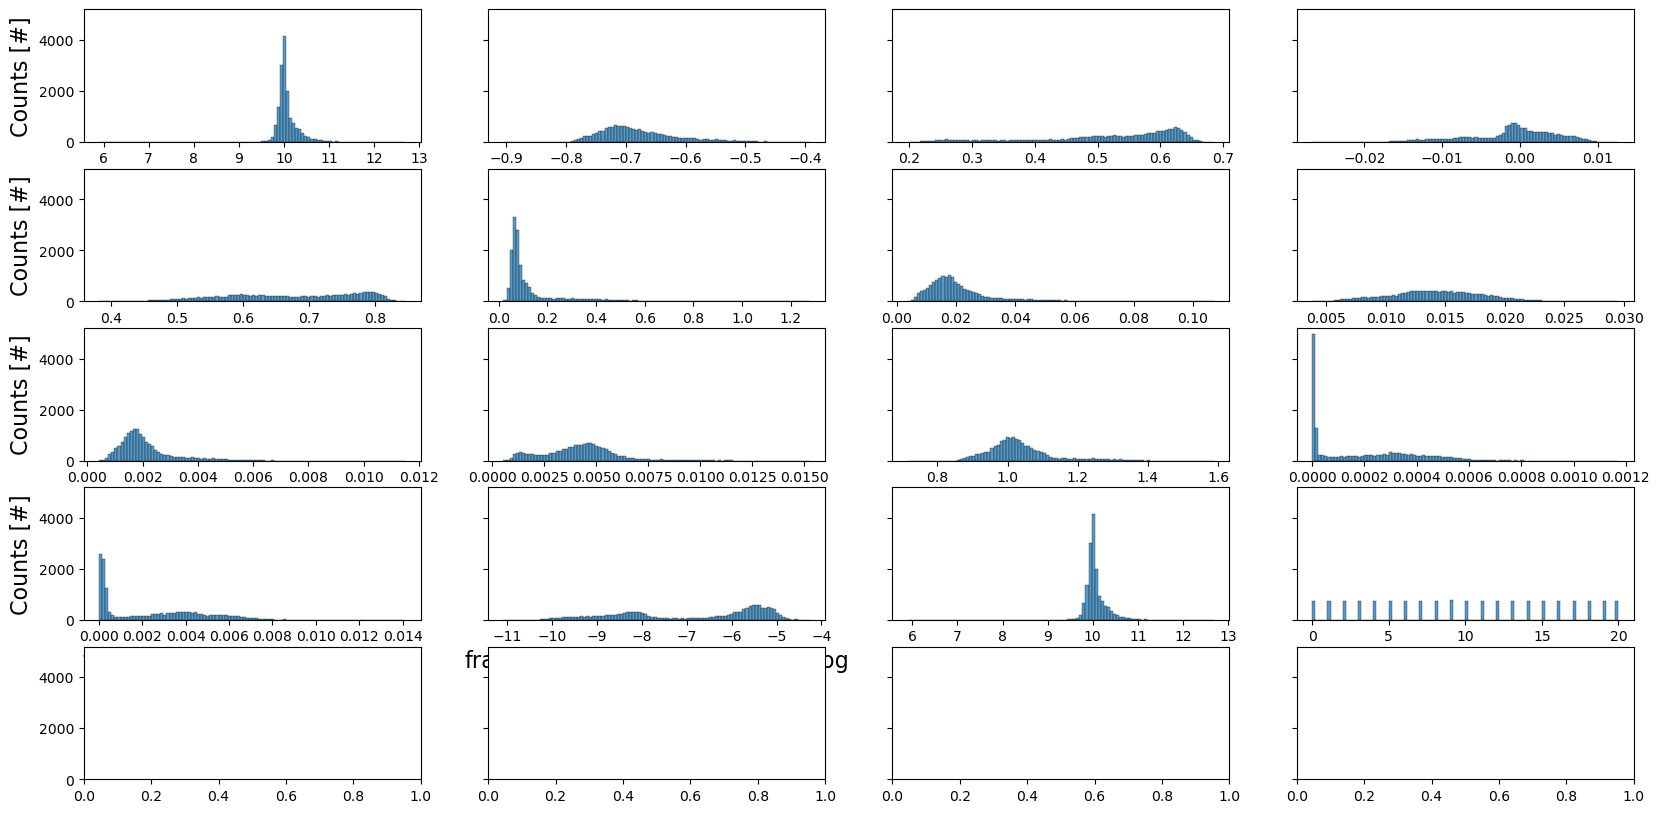

In [22]:
fig, axes = plt.subplots(ncols=4, nrows=len(fit_error_df.columns)//4+1, figsize=(20, 10), sharey=True)
axes = axes.flatten()
for idx, column in enumerate(fit_error_df.columns):
    ax = axes[idx]

    sns.histplot(data=fit_error_df, x=column, ax=ax, bins=100)
    ax.set_xlabel(column, fontsize=16)
    ax.set_ylabel('Counts [#]', fontsize=16)

if save_directory is not None:
    fig.savefig(os.path.join(save_directory, 'fit_error_reconstruction.png'), dpi=300)

## Spherical harmonics

### Fit residue

We now show the errors made when approximating the reconstructed pointcloud with the spherical harmonics:

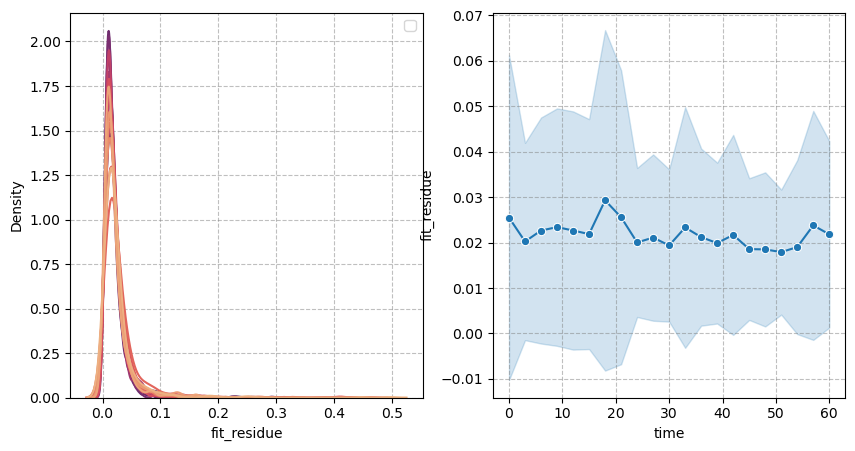

In [23]:
if save_directory is not None:
    fig.savefig(os.path.join(save_directory, figures_dict[list_of_figures[0]]), dpi=300)

fig = list_of_figures[0]
fig

### Fit quality

We can quantify the quality of the extracted pointcloud by using the absolute and relative Gauss-Bonnet errors:

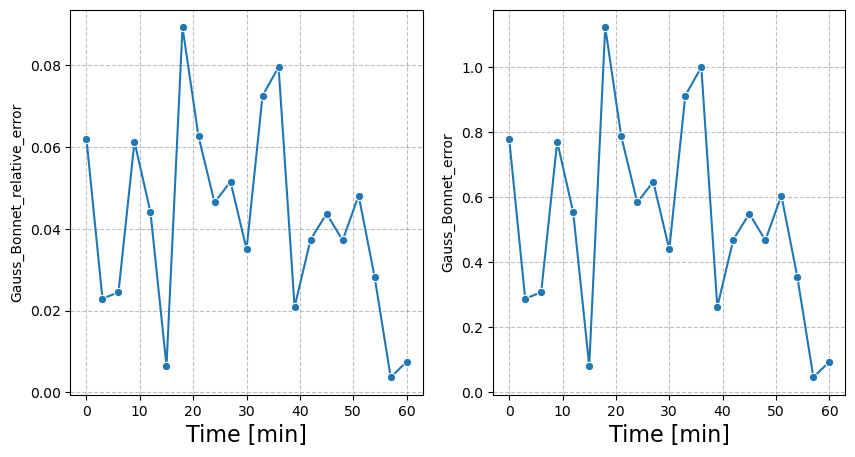

In [24]:
if save_directory is not None:
    fig.savefig(os.path.join(save_directory, figures_dict[list_of_figures[1]]), dpi=300)

fig = list_of_figures[1]

for ax in fig.axes:
    ax.set_xlabel('Time [min]', fontsize=16)

fig

## Curvature

We next show mean curvature histograms and averages over time:

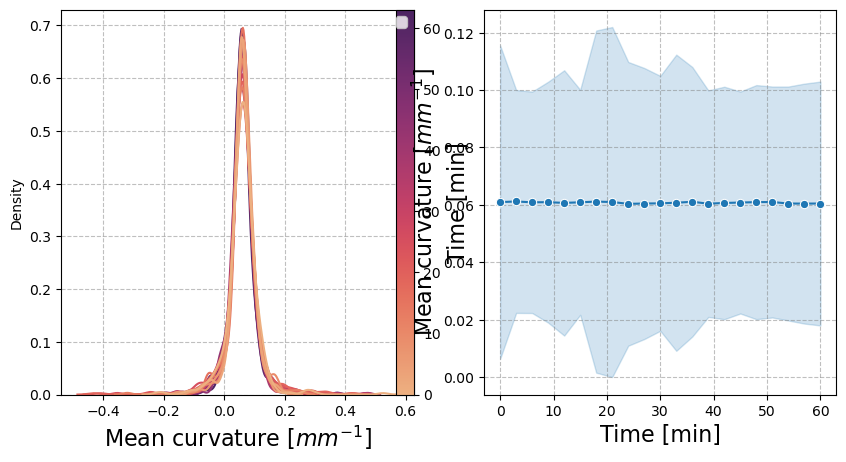

In [25]:
if save_directory is not None:
    fig.savefig(os.path.join(save_directory, figures_dict[list_of_figures[2]]), dpi=300)

fig = list_of_figures[2]

fig.axes[0].set_xlabel("Mean curvature [$mm^{-1}$]", fontsize=16)

fig.axes[1].set_ylabel("Mean curvature [$mm^{-1}$]", fontsize=16)
fig.axes[1].set_xlabel("Time [min]", fontsize=16)

# add a colorbor to the first plot with given max and min value and colormap type
cax = fig.axes[0].inset_axes([0.95, 0, 0.05, 1])
norm = mpl.colors.Normalize(vmin=0, vmax=n_frames*time_step)
cb1 = mpl.colorbar.ColorbarBase(cax, cmap=colormap_time, norm=norm)
cb1.set_label('Time [min]', fontsize=16)

fig

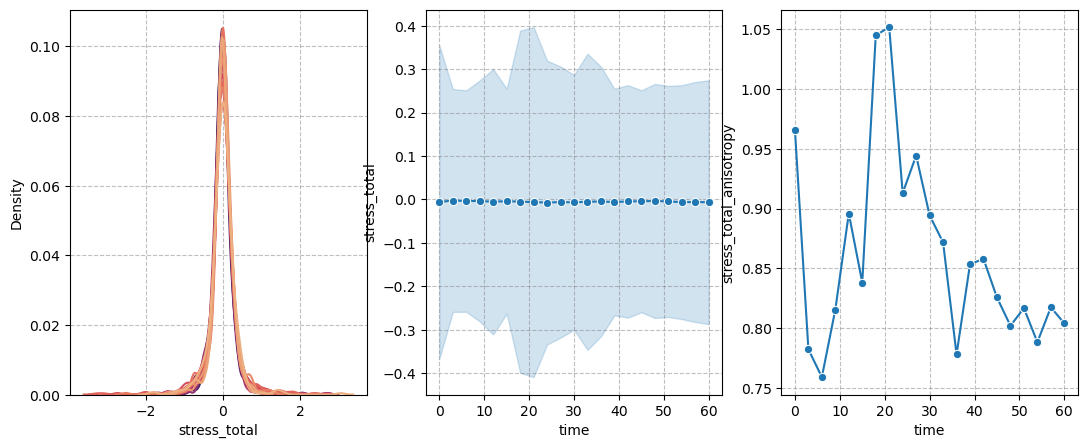

In [26]:
if save_directory is not None:
    fig.savefig(os.path.join(save_directory, figures_dict[list_of_figures[3]]), dpi=300)

list_of_figures[3]

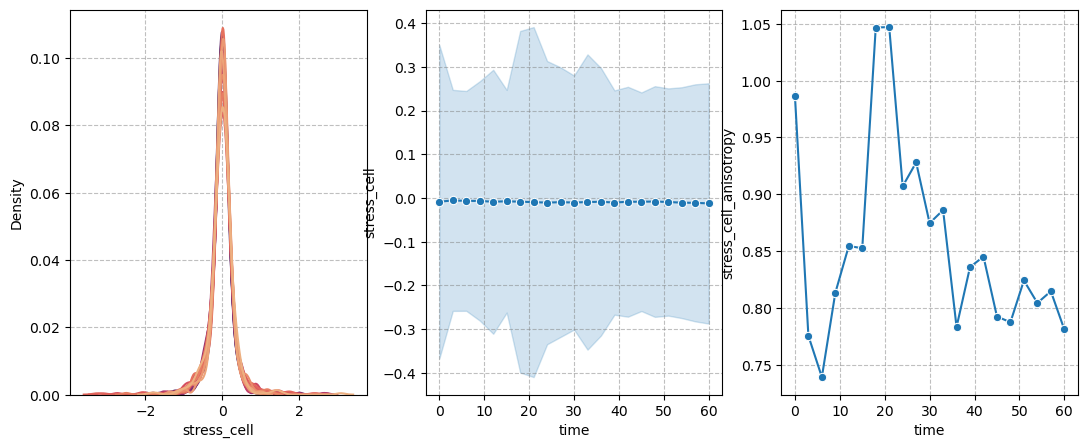

In [27]:
if save_directory is not None:
    fig.savefig(os.path.join(save_directory, figures_dict[list_of_figures[4]]), dpi=300)

list_of_figures[4]

## Tissue-scale stresses

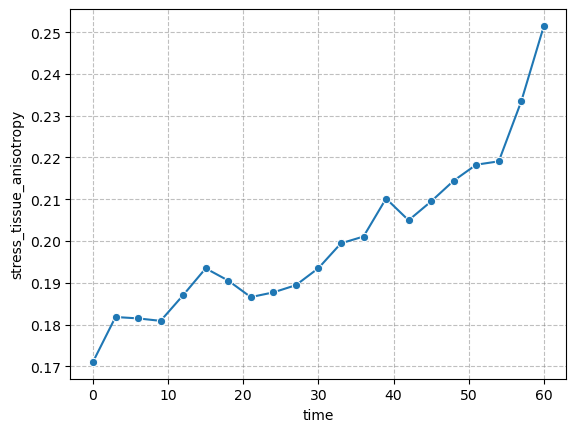

In [28]:
if save_directory is not None:
    fig.savefig(os.path.join(save_directory, figures_dict[list_of_figures[5]]), dpi=300)

list_of_figures[5]

## Stress along axes

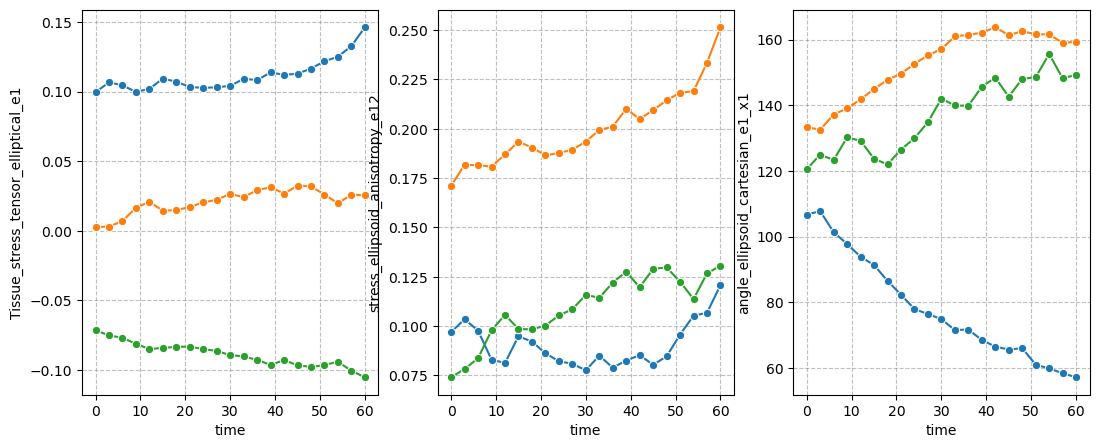

In [29]:
if save_directory is not None:
    fig.savefig(os.path.join(save_directory, figures_dict[list_of_figures[6]]), dpi=300)

fig = list_of_figures[6]
fig

## Extrema analysis

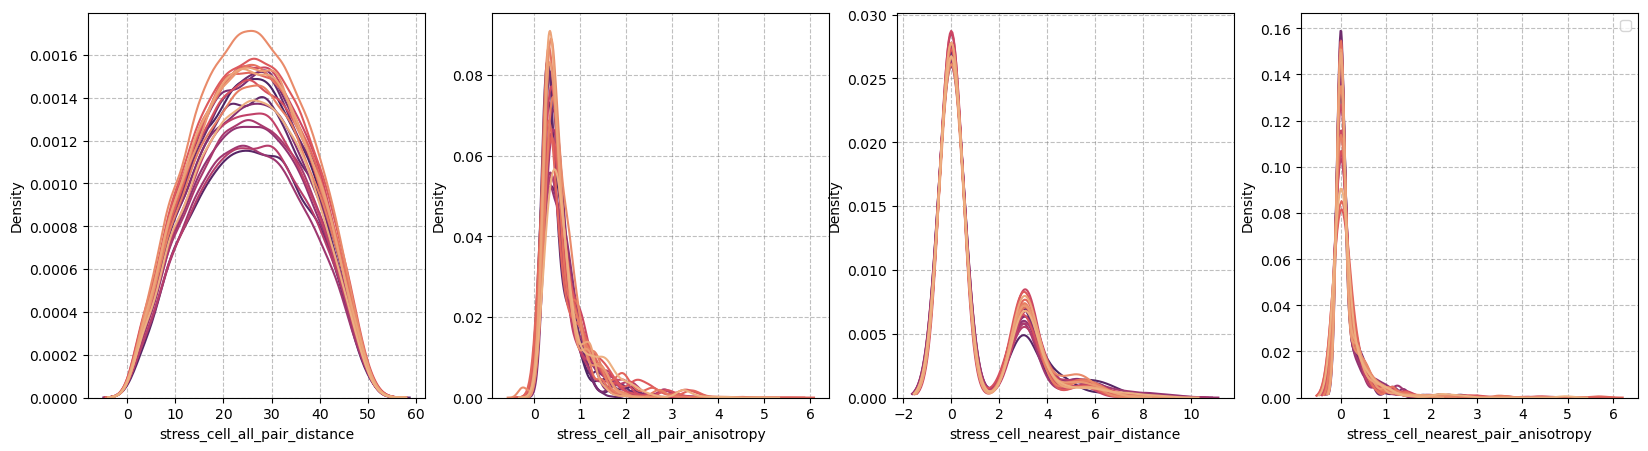

In [30]:
if save_directory is not None:
    fig.savefig(os.path.join(save_directory, figures_dict[list_of_figures[7]]), dpi=300)

fig = list_of_figures[7]
fig

##  Autocorrelations: Spatial

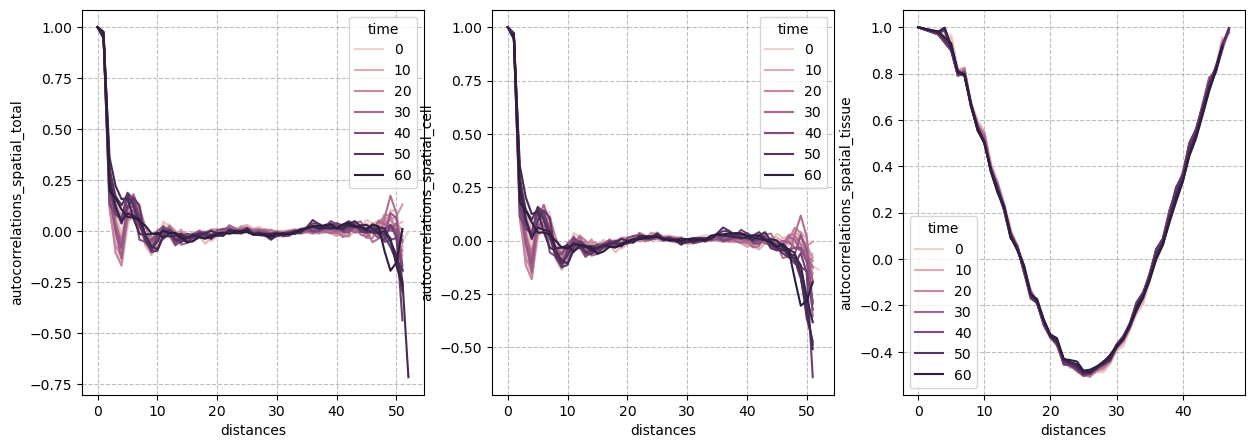

In [31]:
if save_directory is not None:
    fig.savefig(os.path.join(save_directory, figures_dict[list_of_figures[8]]), dpi=300)

fig = list_of_figures[8]
fig

## Autocorrelations: Temporal

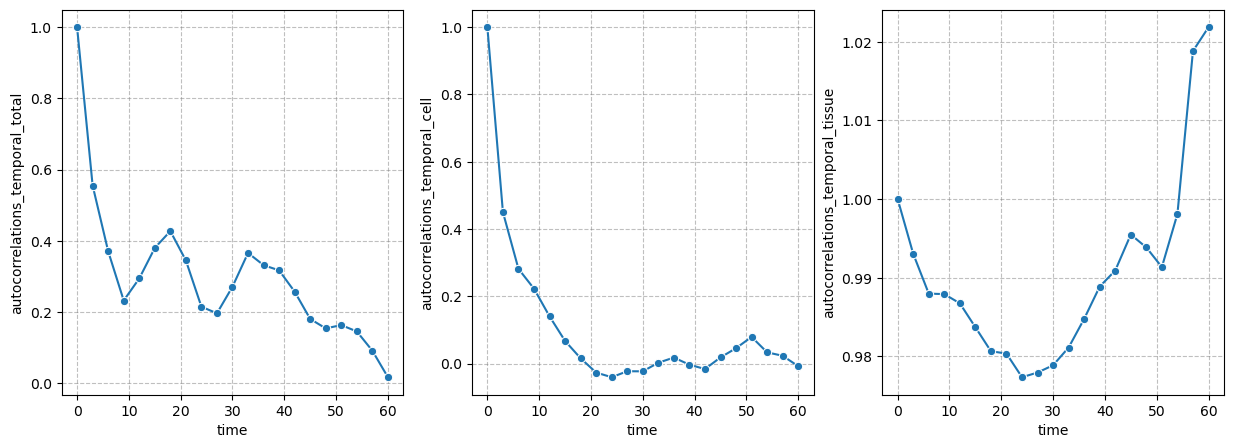

In [32]:
if save_directory is not None:
    fig.savefig(os.path.join(save_directory, figures_dict[list_of_figures[9]]), dpi=300)

fig = list_of_figures[9]
fig

## Ellipsoid deviation

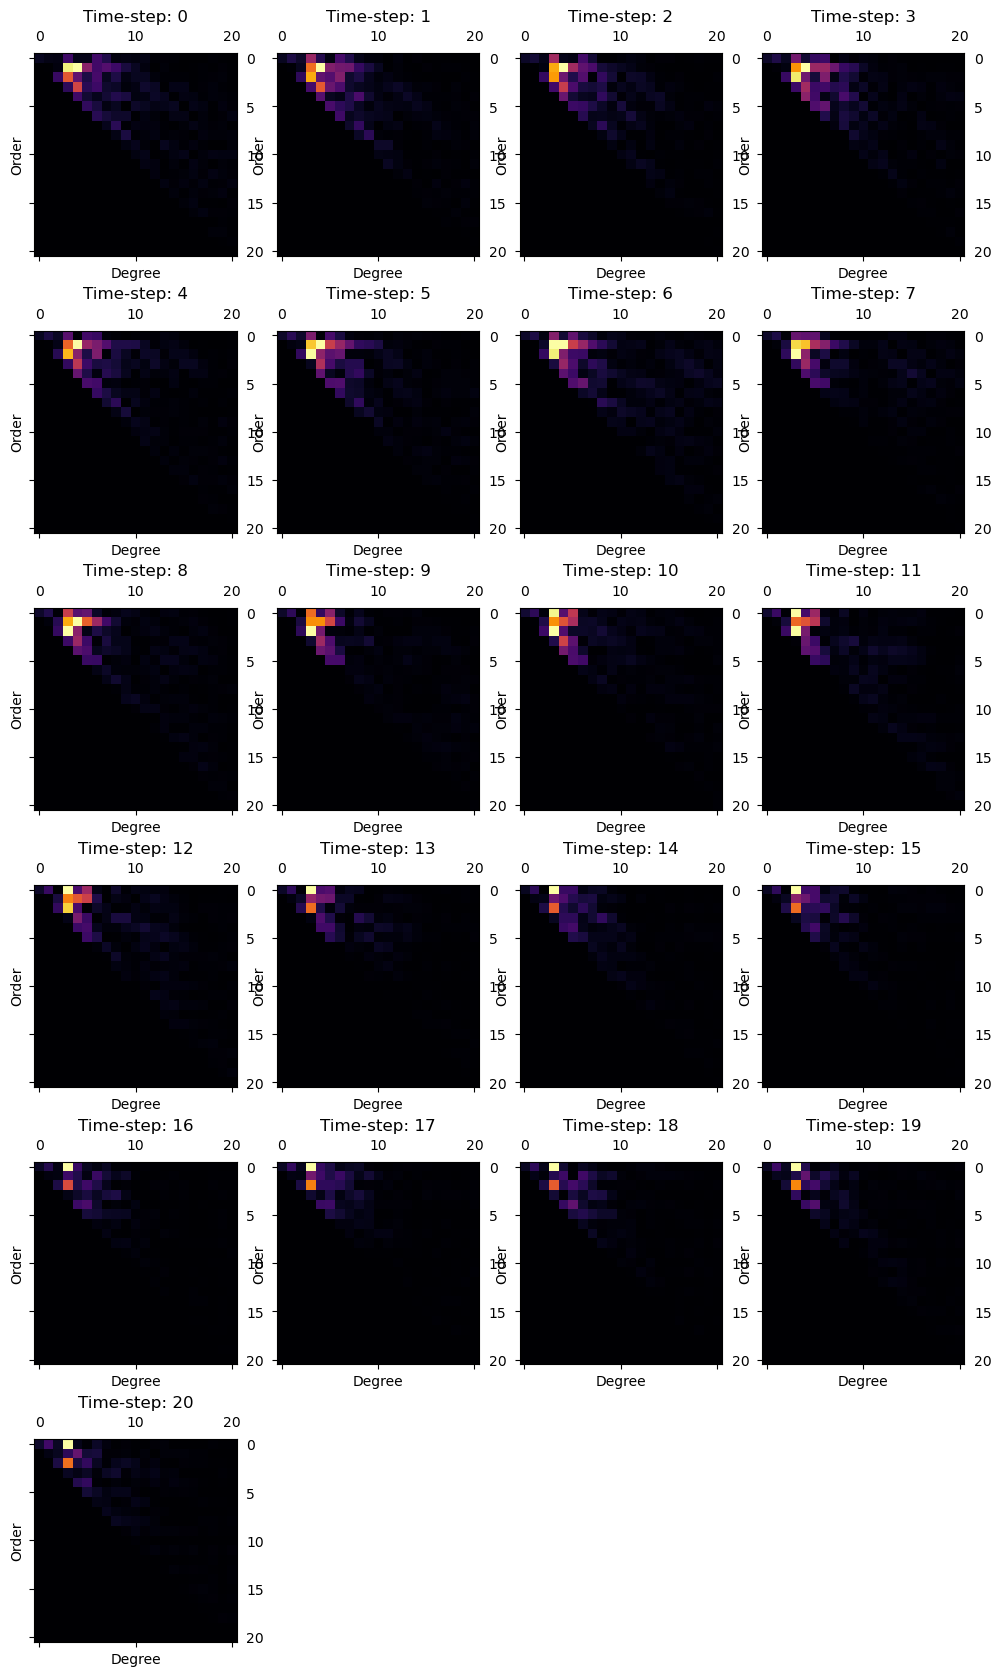

In [33]:
if save_directory is not None:
    fig.savefig(os.path.join(save_directory, figures_dict[list_of_figures[10]]), dpi=300)

fig = list_of_figures[10]
fig

## Droplet movement

This analyzes how much the center of the droplet moves over time.

<Axes: xlabel='time', ylabel='droplet_center_displacement'>

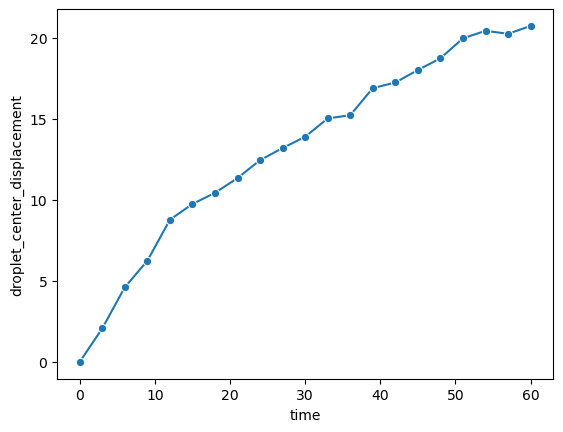

In [34]:
Converter = TimelapseConverter()
list_of_points = Converter.data_to_list_of_data(results_reconstruction[3][0], layertype=napari.types.PointsData)
center = [np.mean(points, axis=0) for points in list_of_points]
center_displacement = np.asarray([np.linalg.norm(center[t] - center[0]) for t in range(n_frames)])
df_over_time['droplet_center_displacement'] =  center_displacement * target_voxel_size

sns.lineplot(data=df_over_time, x='time', y='droplet_center_displacement', marker='o')

## Export data

We first agregate the data from the spatial autocorrelations in a separate dataframe. This dataframe has a column for autocorrelations of total, cell and tissue-scale stresses.

In [35]:
df_to_export = pd.DataFrame()
for col in df_over_time.columns:
    if isinstance(df_over_time[col].iloc[0], np.ndarray):
        continue
    if np.stack(df_over_time[col].to_numpy()).shape == (n_frames,):
        df_to_export[col] = df_over_time[col].to_numpy()

df_to_export.to_csv(os.path.join(save_directory, 'results_over_time.csv'), index=False)

We also export the used settings for the analysis  into a `.yml` file:

In [36]:
utils.export_settings(reconstruction_parameters, file_name=os.path.join(save_directory, 'reconstruction_settings.yaml'))
utils.export_settings(measurement_parameters, file_name=os.path.join(save_directory, 'measurement_settings.yaml'))